# Predicting football matches results (model selection, validation, and prediction)

In this notebook, I will use several machine learning algorithms to predict oucomes of the current 2021/2022 season. For this, I will the preprocessed dataset created in the previous notebook.

All created features are numerical, so I don't need to process them further. I'll split the matches dataframe into train and test:

* Train - 10 seasons, from 2011/2012 to 2020/2021
* Test - season 2021/2022 (ongoing)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectPercentile
from sklearn.pipeline import make_pipeline

import xgboost as xgb
import lightgbm as lgb

In [2]:
matches_all = pd.read_csv(
    'https://raw.githubusercontent.com/osydorchuk89/predicting_football_results/main/data/matches_all.csv'
)
matches_all.drop_duplicates(inplace=True)
train, test = matches_all.iloc[:3800, :], matches_all.iloc[3800:, :]

For validation, I'll divide train into five folds:

1. Train - seasons 2011/2012 to 2015/2016, validation - season 2016/2017
2. Train - seasons 2012/2013 to 2016/2017, validation - season 2017/2018
3. Train - seasons 2013/2014 to 2017/2018, validation - season 2018/2019
4. Train - seasons 2014/2015 to 2018/2019, validation - season 2019/2020
5. Train - seasons 2015/2016 to 2019/2020, validation - season 2020/2021

In [3]:
n = 380 #number of matches in a season

train_1_indices, valid_1_indices = train.iloc[:n*5].index, train.iloc[n*5:n*6].index
train_2_indices, valid_2_indices = train.iloc[n:n*6].index, train.iloc[n*6:n*7].index
train_3_indices, valid_3_indices = train.iloc[n*2:n*7].index, train.iloc[n*7:n*8].index
train_4_indices, valid_4_indices = train.iloc[n*3:n*8].index, train.iloc[n*8:n*9].index
train_5_indices, valid_5_indices = train.iloc[n*4:n*9].index, train.iloc[n*9:n*10].index

my_cv = [
    (train_1_indices, valid_1_indices), 
    (train_2_indices, valid_2_indices), 
    (train_3_indices, valid_3_indices),
    (train_4_indices, valid_4_indices),
    (train_5_indices, valid_5_indices)
]

In [4]:
# instantiating classification algorithms with deafault parameters
logreg = LogisticRegression(solver='liblinear', random_state=17)
rf = RandomForestClassifier(random_state=17)
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', eval_metric='merror')
lgb_clf = lgb.LGBMClassifier(objective='multiclass', metric='multi_error')

In [5]:
X_train = train.drop(columns='result')
y_train = train.result
y_train_num = train.result.map({'away_win': 0, 'draw': 1, 'home_win':2})

For validation, I will use two metrics: 
1. *Accuracy*. Overall share of predictions that turned out to be correct.The higher the better.
2. *Average critical errors*. this is a custom metric I developed for this task. It is calculated a share of away wins predicted as home wins and home wins predicted as away wins. I would like to minimize these errors as they are the most costly. The lower the better.
I will try to optimize predictions for these both scores.

I'll start with computing average accuracy and critical errors of predictions, using four models with defauls parameters: LogisticRegression, RandomForestClassifier, XGBClassifier, and LGBMClassifier.

In [6]:
# custom metric for calclating the share of most costly errors
def critical_errors_func(y_true, y_pred):
    errors = 0
    for pred, true in zip(y_true, y_pred):
        if ((pred == 'home_win') and (true == 'away_win')) or ((pred == 'away_win') and (true == 'home_win')):
            errors += 1
    score = errors / len(y_true)
    return score

critical_errors = make_scorer(critical_errors_func)

In [7]:
base_models = [logreg, rf, xgb_clf, lgb_clf]

accuracy_scores = []
critical_errors_scores = []
model_names = []

for model in base_models:
    model_name = type(model).__name__
    accuracy = cross_val_score(model, X_train, y_train, cv=my_cv, scoring='accuracy').mean() * 100
    critical_errors_score = cross_val_score(model, X_train, y_train, cv=my_cv, scoring=critical_errors).mean() * 100
    model_names.append(model_name)
    accuracy_scores.append(round(accuracy, 2))
    critical_errors_scores.append(round(critical_errors_score, 2))

pd.DataFrame({'Model': model_names, 'Accuracy': accuracy_scores, 'Critical errors': critical_errors_scores})    

,Model,Accuracy,Critical errors
0,LogisticRegression,53.84,21.95
1,RandomForestClassifier,52.68,20.32
2,XGBClassifier,50.58,19.47
3,LGBMClassifier,52.11,19.11


The results of different algorithms are comparable. However, since boosting algorithm have greater potential for improving by changing their hyperparameters, I'll proceed to tuning them.

In [8]:
# tuning XGBoost hyperparameters
xgb_parameters = {
    'objective': 'multi:softmax',
    'eval_metric': 'merror',
    'num_class': 3,
    'learning_rate': 0.05,
    'max_depth': 4,
    'max_leaves': 8,
    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    'colsample_bytree': 0.7,
    'subsample': 0.7
}

xgb_train = xgb.DMatrix(X_train, y_train_num)
xgb_results = xgb.cv(
    xgb_parameters, 
    xgb_train, 
    num_boost_round=100, 
    verbose_eval=10, 
    early_stopping_rounds=20, 
    folds=my_cv
)

xgb_train_results = (1 - xgb_results.iloc[:, 0]) * 100
xgb_test_results = (1 - xgb_results.iloc[:, 2]) * 100
xgb_best_round = len(xgb_results) - 1

xgb_train_result = xgb_train_results[xgb_best_round]
xgb_test_result = xgb_test_results[xgb_best_round]

print(f'\n Best train score is {xgb_train_result:.2f}%, best validation score is {xgb_test_result:.2f}%, achieved after {xgb_best_round} rounds')

[0]	train-merror:0.43821+0.00785	test-merror:0.45053+0.02675
[10]	train-merror:0.42716+0.00688	test-merror:0.43947+0.03000
[20]	train-merror:0.42000+0.00467	test-merror:0.44105+0.02952
[30]	train-merror:0.40989+0.00436	test-merror:0.44211+0.02725
[31]	train-merror:0.41021+0.00366	test-merror:0.44105+0.02707

 Best train score is 57.48%, best validation score is 56.47%, achieved after 12 rounds


In [9]:
# tuning LightGBM hyperparameters
lgb_parameters = {
  'objective': 'multiclass',
  'metric': 'multi_error', 
  'num_class': 3,
  'learning_rate': 0.01,
  'verbose': -1,
  'subsample_freq': 1,
  'subsample': 0.7,
  'colsample_bytree': 0.7, 
  'min_child_samples': 50,
  'random_seed': 17
}

lgb_train = lgb.Dataset(X_train, y_train_num)

lgb_results = lgb.cv(
    lgb_parameters, 
    lgb_train, 
    num_boost_round=1000, 
    folds=my_cv, 
    early_stopping_rounds=100, 
    verbose_eval=10, 
    eval_train_metric=True
)

lgb_test_result = (1 - lgb_results['valid multi_error-mean'][-1]) * 100
lgb_train_result = (1 - lgb_results['train multi_error-mean'][-1]) * 100
lgb_best_round = len(lgb_results['valid multi_error-mean'])

print(
    f'\nBest train score is {lgb_train_result:.2f}%, best validation score is {lgb_test_result:.2f}%, achieved after {lgb_best_round} rounds'
)


[10]	cv_agg's train multi_error: 0.545895 + 0.00499751	cv_agg's valid multi_error: 0.548947 + 0.0388405
[20]	cv_agg's train multi_error: 0.533895 + 0.0153432	cv_agg's valid multi_error: 0.543158 + 0.034896
[30]	cv_agg's train multi_error: 0.472842 + 0.00821862	cv_agg's valid multi_error: 0.491579 + 0.0417551
[40]	cv_agg's train multi_error: 0.451789 + 0.0069154	cv_agg's valid multi_error: 0.468421 + 0.0361208
[50]	cv_agg's train multi_error: 0.442421 + 0.00649398	cv_agg's valid multi_error: 0.459474 + 0.0399654
[60]	cv_agg's train multi_error: 0.434947 + 0.0089356	cv_agg's valid multi_error: 0.451053 + 0.0394772
[70]	cv_agg's train multi_error: 0.426947 + 0.00895913	cv_agg's valid multi_error: 0.446842 + 0.0413886
[80]	cv_agg's train multi_error: 0.415158 + 0.00897766	cv_agg's valid multi_error: 0.442105 + 0.0383164
[90]	cv_agg's train multi_error: 0.404947 + 0.00744025	cv_agg's valid multi_error: 0.441579 + 0.0374905
[100]	cv_agg's train multi_error: 0.392947 + 0.00755112	cv_agg's val

To calculate average critical errors score using 5-fold validation, I will use scikit-learn wrapper of XGBoost and LightGBM.

In [10]:
xgb_parameters['n_estimators'] = 12 #applying early stopping to the algorithm
xgb_clf_upd = xgb.XGBClassifier(**xgb_parameters)

xgb_avg_accuracy = cross_val_score(xgb_clf_upd, X_train, y_train, cv=my_cv, scoring='accuracy').mean() * 100
xgb_avg_critical_error = cross_val_score(xgb_clf_upd, X_train, y_train, cv=my_cv, scoring=critical_errors).mean() * 100

print(f'Average accuracy score of tuned XGBClassifier is {xgb_avg_accuracy:.2f}%')
print(f'\nAverage critical error score of tuned XGBClassifier is {xgb_avg_critical_error:.2f}%')

Average accuracy score of tuned XGBClassifier is 55.84%

Average critical error score of tuned XGBClassifier is 21.16%


In [11]:
lgb_parameters['n_estimators'] = 86 #applying early stopping to the algorithm
lgb_clf_upd = lgb.LGBMClassifier(**lgb_parameters)

lgb_avg_accuracy = cross_val_score(lgb_clf_upd, X_train, y_train, cv=my_cv, scoring='accuracy').mean() * 100
lgb_avg_critical_error = cross_val_score(lgb_clf_upd, X_train, y_train, cv=my_cv, scoring=critical_errors).mean() * 100

print(f'Average accuracy score of tuned LGBMClassifier is {lgb_avg_accuracy:.2f}%')
print(f'\nAverage critical error score of tuned LGBMClassifier is {lgb_avg_critical_error:.2f}%')

Average accuracy score of tuned LGBMClassifier is 55.74%

Average critical error score of tuned LGBMClassifier is 21.74%


To undestand how predicted outcomes compare with actual results over 5 folds, I will create and visualize a confusion matrix. To get predictions from each fold, I will need to recreate this folds and iterate over them manually, since skicit learn's cross_val_predict is not compatible with time series-like cross-validation.

In [12]:
train_1, valid_1 = matches_all.iloc[:n*5], matches_all.iloc[n*5:n*6]
train_2, valid_2 = matches_all.iloc[n:n*6], matches_all.iloc[n*6:n*7]
train_3, valid_3 = matches_all.iloc[n*2:n*7], matches_all.iloc[n*7:n*8]
train_4, valid_4 = matches_all.iloc[n*3:n*8], matches_all.iloc[n*8:n*9]
train_5, valid_5 = matches_all.iloc[n*4:n*9], matches_all.iloc[n*9:n*10]

folds = [
    (train_1, valid_1), 
    (train_2, valid_2), 
    (train_3, valid_3),
    (train_4, valid_4),
    (train_5, valid_5)
]

def train_valid_split(fold):
    X_train = fold[0].drop(columns='result')
    y_train = fold[0].result
    X_valid = fold[1].drop(columns='result')
    y_valid = fold[1].result
    return [X_train, y_train, X_valid, y_valid]

fold_1 = train_valid_split(folds[0])
fold_2 = train_valid_split(folds[1])
fold_3 = train_valid_split(folds[2])
fold_4 = train_valid_split(folds[3])
fold_5 = train_valid_split(folds[4])

folds_new = [fold_1, fold_2, fold_3, fold_4, fold_5]

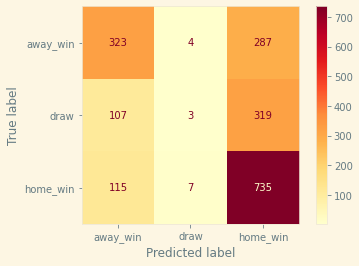

In [13]:
accuracies_folds = []
critical_errors_folds = []
correct_results = []
preds = []

for fold in folds_new:
    xgb_clf_upd.fit(fold[0], fold[1])
    pred = xgb_clf_upd.predict(fold[2])
    accuracy = accuracy_score(fold[3], pred) * 100
    critical_error = critical_errors_func(fold[3], pred) * 100
    preds.append(pred)
    correct_results.append(fold[3])
    accuracies_folds.append(accuracy)
    critical_errors_folds.append(critical_error)

correct_results_flat = [item for sublist in correct_results for item in sublist]
preds_flat = [item for sublist in preds for item in sublist]

cm = confusion_matrix(correct_results_flat, preds_flat, labels=['away_win', 'draw', 'home_win'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['away_win', 'draw', 'home_win']).plot(cmap='YlOrRd')
plt.grid(False)
plt.show()

In [14]:
# displaying the counts of predicted away wins, draws, and home wins accross all 5 folds
unique, counts = np.unique(preds_flat, return_counts=True)
print(np.asarray((unique, counts)).T)

[['away_win' '545']
 ['draw' '14']
 ['home_win' '1341']]


From the confusion matrix and the counts of predicted outcomes, it is obvious that the model singinficantly underestimates the probability of draw and overestimates the probability of home win. To address this, I will try to manually tweak the threshols for predicting draw and home win from predicted probabilities. It is reasonable to assume if a difference of probabilities between home and away win is very small, the model can predict draw even if the probability of draw is lower than the probabilities of either home and away win.

In [15]:
def cross_val_custom_threshold(model):
    accuracies_folds = []
    critical_errors_folds = []

    for fold in folds_new:
        model.fit(fold[0], fold[1])
        preds = model.predict(fold[2])
        probs = model.predict_proba(fold[2])

        upd_preds = []

        for row in probs:
            if (row[0] > row[1]) & (row[0] > row[2]):
                upd_preds.append('away_win')
            elif (row[2] > row[1]) & (row[2] > row[0]) & ((row[2] - row[0]) > 0.05):
                upd_preds.append('home_win')
            else:
                upd_preds.append('draw')

        accuracy = accuracy_score(fold[3], upd_preds) * 100
        critical_error = critical_errors_func(fold[3], upd_preds) * 100
        accuracies_folds.append(accuracy)
        critical_errors_folds.append(critical_error)

    accuracy_upd = np.mean(accuracies_folds)
    critical_error_upd = np.mean(critical_errors_folds)
    
    return accuracy_upd, critical_error_upd

In [16]:
xgb_avg_accuracy_upd = cross_val_custom_threshold(xgb_clf_upd)[0]
xgb_avg_critical_error_upd = cross_val_custom_threshold(xgb_clf_upd)[1]

print(f'Average accuracy score of tuned XGBoost before customization: {xgb_avg_accuracy:.2f}%')
print(f'Average accuracy score of tuned XGBoost after customization: {xgb_avg_accuracy_upd:.2f}%')
print(f'\nAverage critical error score of tuned XGBoost before customization: {xgb_avg_critical_error:.2f}%')
print(f'Average critical error score of tuned XGBoost after customization: {xgb_avg_critical_error_upd:.2f}%')

Average accuracy score of tuned XGBoost before customization: 55.84%
Average accuracy score of tuned XGBoost after customization: 54.58%

Average critical error score of tuned XGBoost before customization: 21.16%
Average critical error score of tuned XGBoost after customization: 15.68%


In [17]:
lgb_avg_accuracy_upd = cross_val_custom_threshold(lgb_clf_upd)[0]
lgb_avg_critical_error_upd = cross_val_custom_threshold(lgb_clf_upd)[1]

print(f'Average accuracy score of tuned LightGBM before customization: {lgb_avg_accuracy:.2f}%')
print(f'Average accuracy score of tuned LightGBM after customization: {lgb_avg_accuracy_upd:.2f}%')
print(f'\nAverage critical error score of tuned LightGBM before customization: {lgb_avg_critical_error:.2f}%')
print(f'Average critical error score of tuned LightGBM after customization: {lgb_avg_critical_error_upd:.2f}%')

Average accuracy score of tuned LightGBM before customization: 55.74%
Average accuracy score of tuned LightGBM after customization: 55.32%

Average critical error score of tuned LightGBM before customization: 21.74%
Average critical error score of tuned LightGBM after customization: 19.42%


After experimenting with changing thresholds for predicting different classes, I decided to change the threshold for predicting home win. In other words, less cases will be classified as home wins and more as draws. This decreased the accuracy a bit but also lowered the critical error more significantly.

I will now turn to predictions. As a baseline, I will assume that all matches in the season 2021/2022 result in home wins as the most frequent outcome from the training set.

In [18]:
X_test = test.drop(columns='result')
y_test = test.result

In [19]:
baseline_preds = np.full((214,), 'home_win')
baseline_accuracy = accuracy_score(y_test, baseline_preds) * 100
baseline_critical_errors = critical_errors_func(y_test, baseline_preds) * 100

print(f'Accuracy of predictions on test using baseline: {baseline_accuracy:.2f}%')
print(f'\nCritical errors score of predictions on test using baseline: {baseline_critical_errors:.2f}%')

Accuracy of predictions on test using baseline: 40.65%

Critical errors score of predictions on test using baseline: 32.71%


Now, I will compare the predictions of XGBClassifier with default and customied prediction thresholds on the test set.

In [20]:
# increasing the number of estimators as the model trains on the bigger set

xgb_parameters['n_estimators'] = 15 
xgb_clf_final = xgb.XGBClassifier(**xgb_parameters)

lgb_parameters['n_estimators'] = 90
lgb_clf_final = lgb.LGBMClassifier(**lgb_parameters)

In [21]:
def tuned_model_predict(model):
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy_test = accuracy_score(y_test, preds) * 100
    critical_error_test = critical_errors_func(y_test, preds) * 100
    
    return accuracy_test, critical_error_test, preds

In [22]:
def customized_model_predict(model):
    
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)

    upd_preds = []

    for row in probs:
        if (row[0] > row[1]) & (row[0] > row[2]):
            upd_preds.append('away_win')
        elif (row[2] > row[1]) & (row[2] > row[0]) & ((row[2] - row[0]) > 0.05):
            upd_preds.append('home_win')
        else:
            upd_preds.append('draw')

    accuracy_test = accuracy_score(y_test, upd_preds) * 100
    critical_errors_test = critical_errors_func(y_test, upd_preds) * 100
    
    return accuracy_test, critical_errors_test, upd_preds, probs

In [23]:
tuned_xgb_accuracy_test = tuned_model_predict(xgb_clf_final)[0]
tuned_xgb_critical_errors_test = tuned_model_predict(xgb_clf_final)[1]

customized_xgb_accuracy_test = customized_model_predict(xgb_clf_final)[0]
customized_xgb_critical_errors_test = customized_model_predict(xgb_clf_final)[1]

print(f'Accuracy of predictions on test using tuned XGBoost: {tuned_xgb_accuracy_test:.2f}%')
print(f'Critical errors score of predictions on test using tuned XGBoost: {tuned_xgb_critical_errors_test:.2f}%')
print(f'\nAccuracy of predictions on test using customized XGBoost: {customized_xgb_accuracy_test:.2f}%')
print(f'Critical errors score of predictions on test using customized XGBoost: {customized_xgb_critical_errors_test:.2f}%')

Accuracy of predictions on test using tuned XGBoost: 54.67%
Critical errors score of predictions on test using tuned XGBoost: 18.69%

Accuracy of predictions on test using customized XGBoost: 56.07%
Critical errors score of predictions on test using customized XGBoost: 14.95%


In [24]:
tuned_lgb_accuracy_test = tuned_model_predict(lgb_clf_final)[0]
tuned_lgb_critical_errors_test = tuned_model_predict(lgb_clf_final)[1]

customized_lgb_accuracy_test = customized_model_predict(lgb_clf_final)[0]
customized_lgb_critical_errors_test = customized_model_predict(lgb_clf_final)[1]

print(f'Accuracy of predictions on test using tuned LightGBM: {tuned_lgb_accuracy_test:.2f}%')
print(f'Critical errors score of predictions on test using tuned LightGBM: {tuned_lgb_critical_errors_test:.2f}%')
print(f'\nAccuracy of predictions on test using customized LightGBM: {customized_lgb_accuracy_test:.2f}%')
print(f'Critical errors score of predictions on test using customized LightGBM: {customized_lgb_critical_errors_test:.2f}%')

Accuracy of predictions on test using tuned LightGBM: 51.40%
Critical errors score of predictions on test using tuned LightGBM: 21.96%

Accuracy of predictions on test using customized LightGBM: 51.40%
Critical errors score of predictions on test using customized LightGBM: 18.22%


As we can see, changing the prediction threshold improved the accuracy of predictions and decreased the number of critical erfrors for XGBoost. Below, I will compare the results of predictions between all models visually.

In [25]:
logreg_accuracy_test = tuned_model_predict(logreg)[0]
rf_accuracy_test = tuned_model_predict(rf)[0]
logreg_critical_errors_test = tuned_model_predict(logreg)[1]
rf_critical_errors_test = tuned_model_predict(rf)[1]

In [26]:
test_accuracies = [
    logreg_accuracy_test,
    rf_accuracy_test,
    tuned_xgb_accuracy_test, 
    customized_xgb_accuracy_test, 
    tuned_lgb_accuracy_test, 
    customized_lgb_accuracy_test
]

test_critical_errors = [
    logreg_critical_errors_test,
    rf_critical_errors_test,
    tuned_xgb_critical_errors_test,
    customized_xgb_critical_errors_test,
    tuned_lgb_critical_errors_test,
    customized_lgb_critical_errors_test
]

models = ['LogisticRegression', 'Random Forest', 'Tuned XGBoost', 'Customized XGboost', 'Tuned LightGBM', 'Customized LightGBM']

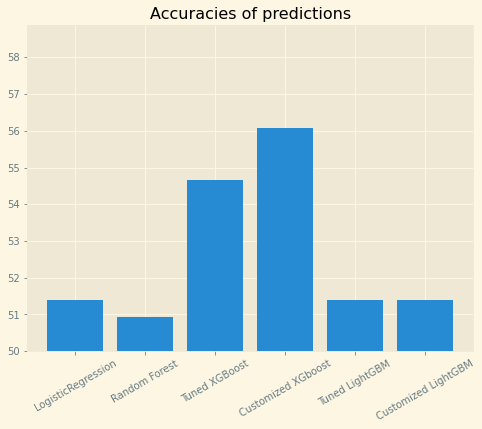

In [27]:
plt.figure(figsize=(8, 6))

plt.bar(models, test_accuracies)
plt.title('Accuracies of predictions')
plt.ylim(50)
plt.xticks(rotation=30)
plt.show()

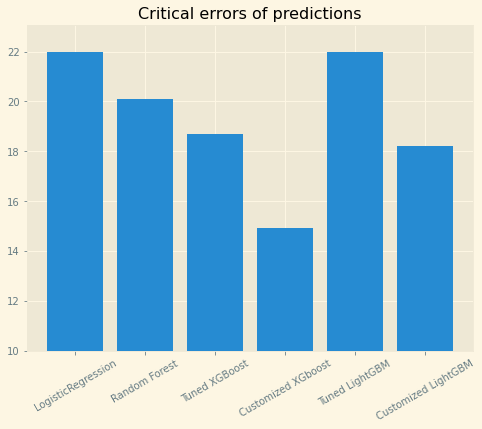

In [28]:
plt.figure(figsize=(8, 6))

plt.bar(models, test_critical_errors)
plt.title('Critical errors of predictions')
plt.ylim(10)
plt.xticks(rotation=30)
plt.show()

As can be seen, customized XGBoost produced the best results. I will analyze its predictions next.

In [29]:
xgb_preds = customized_model_predict(xgb_clf_final)[2]
unique, counts = np.unique(xgb_preds, return_counts=True)
print(np.asarray((unique, counts)).T)

[['away_win' '83']
 ['draw' '29']
 ['home_win' '102']]


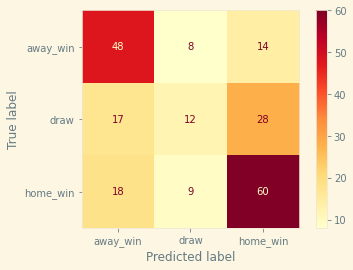

In [30]:
cm = confusion_matrix(y_test, xgb_preds, labels=['away_win', 'draw', 'home_win'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['away_win', 'draw', 'home_win']).plot(cmap='YlOrRd')
plt.grid(False)
plt.show()

In [31]:
print(classification_report(y_test, xgb_preds, labels=['away_win', 'draw', 'home_win']))

              precision    recall  f1-score   support

    away_win       0.58      0.69      0.63        70
        draw       0.41      0.21      0.28        57
    home_win       0.59      0.69      0.63        87

    accuracy                           0.56       214
   macro avg       0.53      0.53      0.51       214
weighted avg       0.54      0.56      0.54       214



The number of cases predicted as draws increased, and the number of critical errors decreased a bit.

Let's examine importance of different features.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

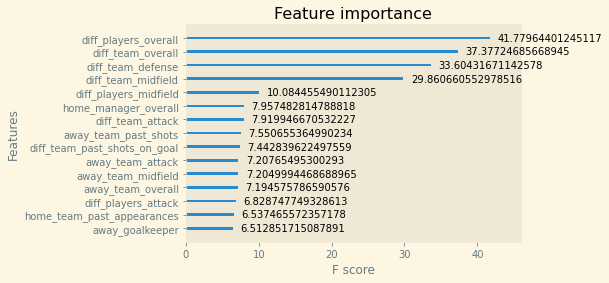

In [32]:
xgb.plot_importance(xgb_clf_final, importance_type='gain', max_num_features=15, grid=False)

The most important features are those related to difference between teams' and players' attributes. This is not surprising as they related to the outcome of the match directly. Overall difference in means of players' and teams' skills seem the most important, followed by the difference in teams' defense and midfield attributes.

I will now create dataframe that wil combine predictions, probabilities of different outcomes, and actual results.

In [33]:
xgb_probs = customized_model_predict(xgb_clf_final)[3]

probs_home_win = []
probs_draw = []
probs_away_win = []

for row in xgb_probs:
    prob_away_win = row[0] * 100
    prob_draw = row[1] * 100
    prob_home_win = row[2] * 100
    probs_away_win.append(prob_away_win)
    probs_draw.append(prob_draw)
    probs_home_win.append(prob_home_win)

In [34]:
predicted_results = pd.DataFrame({
    'prediction': xgb_preds, 
    'home_win_probability': np.round(probs_home_win, 2), 
    'draw_probability': np.round(probs_draw, 2), 
    'away_win_probability': np.round(probs_away_win, 2),
    'actual_result': y_test
})

In [35]:
matches = pd.read_csv(
    'https://raw.githubusercontent.com/osydorchuk89/predicting_football_results/main/raw_data/matches.csv'
)
matches.drop_duplicates(inplace=True)
matches_2021 = matches[matches.year==2021]

In [36]:
predicted_results.insert(0, 'home_team', matches_2021.home.values)
predicted_results.insert(1, 'away_team', matches_2021.away.values)

In [37]:
predicted_results.head()

,home_team,away_team,prediction,home_win_probability,draw_probability,away_win_probability,actual_result
3800,Brentford,Arsenal,away_win,32.53,29.56,37.91,home_win
3801,Manchester United,Leeds United,home_win,50.08,25.48,24.44,home_win
3802,Burnley,Brighton & Hove Albion,home_win,41.99,28.15,29.86,away_win
3803,Chelsea,Crystal Palace,home_win,53.69,23.89,22.42,home_win
3804,Everton,Southampton,home_win,45.92,29.47,24.61,home_win


The dataframe above includes information about matches in season 2021/2022 that has already happened. Next, I will add information about future matches. In this case, however, we don't know the actual results as these matches haven't happened yet.

In [38]:
future_matches_names = pd.read_csv(
    'https://raw.githubusercontent.com/osydorchuk89/predicting_football_results/main/data/future_matches_2021.csv'
)

I will predict outcomes of future matches using only team-related attributes since we don't know the starting lineups of teams for future matches.

In [39]:
team_attributes = [col for col in train.columns if 'team' in col]

X_train_only_teams = train[team_attributes]

test_future = pd.read_csv(
    'https://raw.githubusercontent.com/osydorchuk89/predicting_football_results/main/data/future_matches_numerical.csv'
)

To predict the outcomes of future matches, I will use the same customized XGBoost model.

In [40]:
xgb_clf_final.fit(X_train_only_teams, y_train)
future_probs = xgb_clf_final.predict_proba(test_future)

upd_future_preds = []

for row in future_probs:
    if (row[0] > row[1]) & (row[0] > row[2]):
        upd_future_preds.append('away_win')
    elif (row[2] > row[1]) & (row[2] > row[0]) & ((row[2] - row[0]) > 0.05):
        upd_future_preds.append('home_win')
    else:
        upd_future_preds.append('draw')

In [41]:
future_probs_home_win = []
future_probs_draw = []
future_probs_away_win = []

for row in future_probs:
    future_prob_away_win = row[0] * 100
    future_prob_draw = row[1] * 100
    future_prob_home_win = row[2] * 100
    future_probs_away_win.append(future_prob_away_win)
    future_probs_draw.append(future_prob_draw)
    future_probs_home_win.append(future_prob_home_win)

In [42]:
future_results = pd.DataFrame({
    'prediction': upd_future_preds, 
    'home_win_probability': np.round(future_probs_home_win, 2), 
    'draw_probability': np.round(future_probs_draw, 2), 
    'away_win_probability': np.round(future_probs_away_win, 2)
})

In [43]:
future_results.insert(0, 'home_team', future_matches_names.home.values)
future_results.insert(1, 'away_team', future_matches_names.away.values)

In [44]:
# combining matches that has already happened with future matches into one dataframe
combined_predictions = pd.concat([predicted_results, future_results], ignore_index=True)
combined_predictions.fillna('Unknown yet', inplace=True)
combined_predictions.replace({'away_win': 'Away team win', 'draw': 'Draw', 'home_win': 'Home team win'}, inplace=True)

In [45]:
combined_predictions.tail()

,home_team,away_team,prediction,home_win_probability,draw_probability,away_win_probability,actual_result
375,Crystal Palace,Manchester United,Away team win,25.39,25.42,49.19,Unknown yet
376,Leicester City,Southampton,Home team win,45.32,30.71,23.97,Unknown yet
377,Liverpool,Wolverhampton Wanderers,Home team win,49.68,24.50,25.81,Unknown yet
378,Manchester City,Aston Villa,Home team win,52.78,24.11,23.11,Unknown yet
379,Norwich City,Tottenham Hotspur,Away team win,26.37,28.23,45.40,Unknown yet


In [46]:
combined_predictions.to_csv('combined_predictions.csv', index=False)

Overall, the accuracy of the predictions remains not very high, even after tuning model hyperparameters and manually tweaking the prediction thresholds. Most likely, this is due to two main factors. First, there is usually quite a lot of randomness in how a given football match unfolds and observable features can explain actual outcomes only up to a certain point. Second, the model performabnce can improve if we add more features and more complex features, such as expected goals (xG) of teams and players, conditions of players, attributes of substitute players (those who join the match after it has already started by substituting another player), more robust and up-to-date rankings of football managers etc. Adding these features has the potential to improve the performance of the model and accuracy of its predictions.